In [16]:
import Ouzo_Graph_Tools as ouzo_graphs
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
from scipy import interpolate

In [2]:
# Step 1: Load the csv created from the command script.
sample_info = pd.read_csv(r"C:\Users\Edwin\Desktop\11_17_2020\experiment_info") # make it find the blank position from sample_info
pfh_wtfs = [float(i) for i in list(sample_info['Component 3 wtf'])[1:]]
etoh_wtfs = [float(i) for i in list(sample_info['Component 4 wtf'])[1:]]

In [3]:
# Step 2: Load the UV-Vis data,blank and combine it. 
plate1 =  pd.read_excel(r"C:\Users\Edwin\Desktop\11_17_2020\11_17_2020_Plate123.xlsx", sheet_name = 'Sheet1' ).T
plate2 =  pd.read_excel(r"C:\Users\Edwin\Desktop\11_17_2020\11_17_2020_Plate123.xlsx", sheet_name = 'Sheet2' ).T
plate3 =  pd.read_excel(r"C:\Users\Edwin\Desktop\11_17_2020\11_17_2020_Plate123.xlsx", sheet_name = 'Sheet3' ).T

In [4]:
# Step 3: Correct all data using baseline/blanking, make series first then subtract using .bbaselinecorrection
blank_series = plate3.iloc[12]
plate1_blanked = ouzo_graphs.baseline_correction(plate1, blank_series)
plate2_blanked = ouzo_graphs.baseline_correction(plate2, blank_series)
plate3_blanked = ouzo_graphs.baseline_correction(plate3, blank_series)

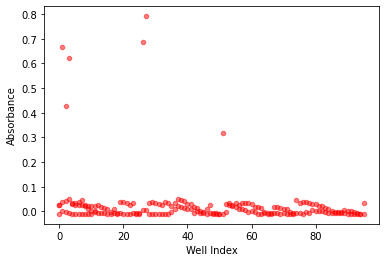

In [14]:
# Step 4: Extract the absorbances from the loaded UV-Vis data at a specified wavelength
wavelength = 400
plate1_absorbances = ouzo_graphs.plot_single_wavelength(plate1_blanked, wavelength)# rearrnge x axis based on concentration or something
plate2_absorbances = ouzo_graphs.plot_single_wavelength(plate2_blanked, wavelength)
plate3_absorbances = ouzo_graphs.plot_single_wavelength(plate3_blanked, wavelength)
# plt.ylim([-0.01,0.02])
# hmm how much varience is okay? and how to handle negative abs after blanking,maybe just the resolution limit of 0.001, so anything 0.01 is the max

In [10]:
# step 5 combine and reorganize
combined_absorbances = plate1_absorbances + plate2_absorbances + plate3_absorbances

# restrict if analyzed to many cells
combined_restricted_xyz = [etoh_wtfs[0:-1],pfh_wtfs[0:-1], combined_absorbances[0:-1]]

In [11]:
# exclude outliers
def exclude_outliers(xyz_list, lower_outlier_z_value, upper_outlier_z_value):
    x_list = xyz_list[0]
    y_list = xyz_list[1]
    z_list = xyz_list[2]
    
    new_x_list = []
    new_y_list = []
    new_z_list = []
    for x,y,z in zip(x_list, y_list, z_list):
        if lower_outlier_z_value<z<upper_outlier_z_value:
            new_x_list.append(x)
            new_y_list.append(y)
            new_z_list.append(z)
    
    return [new_x_list, new_y_list, new_z_list]

In [12]:
# what you should do is use stats to explain and reason outliers in addition to plotting nonoutliter reduced graph
# combined_restricted_xyz = exclude_outliers(combined_restricted_xyz, -0.1, 0.1)
min_x = min(combined_restricted_xyz[0])
max_x = max(combined_restricted_xyz[0])
min_y = min(combined_restricted_xyz[1])
max_y = max(combined_restricted_xyz[1])
min(combined_restricted_xyz[2])

-0.009999999999999995

C:\Users\Edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.4, 0.002, '*Negative AU values due to \n instrument resolution of 0.001 AU')

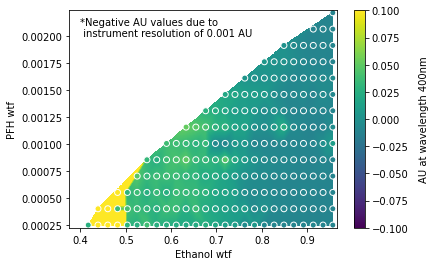

In [38]:
### First make the xx,yy coordinates that the interpolation will span
x_space = np.linspace(min_x,max_x,500)  # change vmax so it
y_space = np.linspace(min_y,max_y,500)
xx, yy = np.meshgrid(x_space,y_space) 

### Next make tuple the x,y data so it can be fed into interpolation method to make the interpolation mesh

cartcoord = list(zip(combined_restricted_xyz[0],combined_restricted_xyz[1]))
interp = interpolate.LinearNDInterpolator(cartcoord, combined_restricted_xyz[2])
Z0 = interp(xx,yy)

# Finally, create the plot. 
# Note: Mappable for the interpolation is independent of the scatter colormap (which is created automatically), they are the same when you do not restrict either.
# Restriction is defined once you restrict the x/y space of the mesh to a space smaller than that of the scatter plot. 

fig, ax = plt.subplots()
vmin = 0
vmax = Z0.max()
norm=colors.Normalize(vmin=vmin, vmax=vmax)

mappable = ax.pcolormesh(xx, yy, Z0, norm=norm)
ax.scatter(combined_restricted_xyz[0], combined_restricted_xyz[1], 
           c = combined_restricted_xyz[2], norm=norm, cmap = mpl.cm.viridis, edgecolors='w')

cbar = plt.colorbar(mappable)
cbar_txt = "AU at wavelength " + str(wavelength) + 'nm'
cbar.set_label(cbar_txt, labelpad = 10)
ax.set_xlim([min_x-min_x/10, max_x+max_x/100]) # simple ratios for easy viewing
ax.set_ylim([min_y-min_y/10, max_y+max_y/100])
ax.set_xlabel("Ethanol wtf")
ax.set_ylabel("PFH wtf")
ax.text(0.4,0.002,'*Negative AU values due to \n instrument resolution of 0.001 AU')
# ax.set_xlim([0.4,0.5])

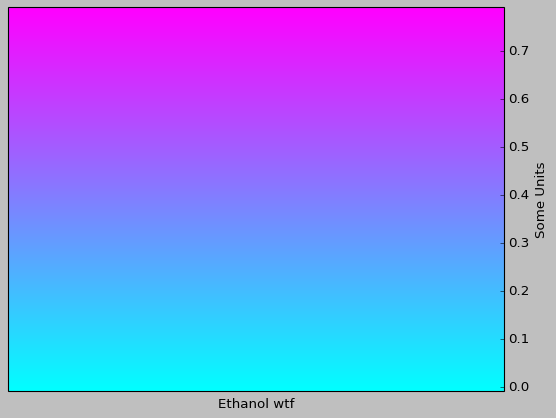

In [41]:
# changing to fig, ax notation
fig, ax = plt.subplots()
ax.scatter(etoh_wtfs, pfh_wtfs, s=100, c = combined_absorbances)
ax.set_xlabel("Ethanol wtf")
ax.set_ylabel("PFH wtf")
# mappable = ax.pcolormesh(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Some Units')

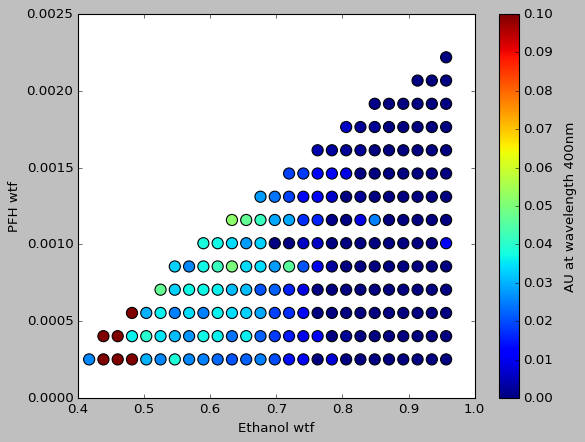

In [71]:
plt.style.use('classic')
plt.scatter(etoh_wtfs, pfh_wtfs, s=100, c = combined_absorbances)
plt.xlabel("Ethanol wtf")
plt.ylabel("PFH wtf")
color_bar = plt.colorbar()
color_bar_txt = "AU at wavelength " + str(wavelength) + 'nm'
color_bar.set_label(color_bar_txt, labelpad = 10)
plt.xlim([0.4,1])
plt.ylim([0, 0.0025])
plt.clim(0, 0.1)
# esentially need to figure out a absorbance which will be a cut off, so we cannot go berlow 0;01
# mappable = ax.pcolormesh(xx, yy, Z0,cmap=cm.inferno)
# how will I automate this

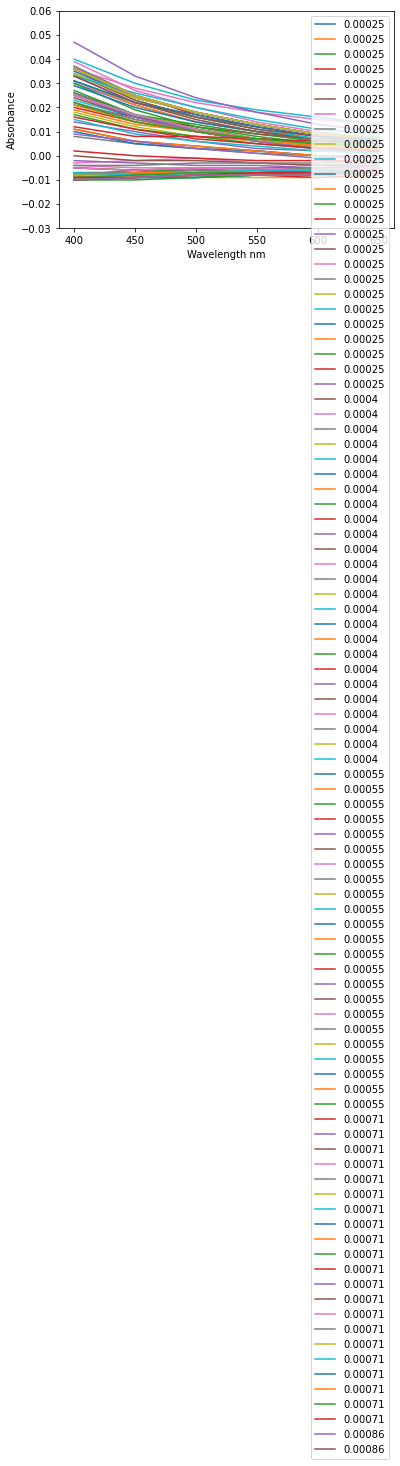

In [114]:
df = plate1_blanked
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded, y_lim=[-0.03,0.06]) # so still under resolution
# can you do a color bar like image on this 

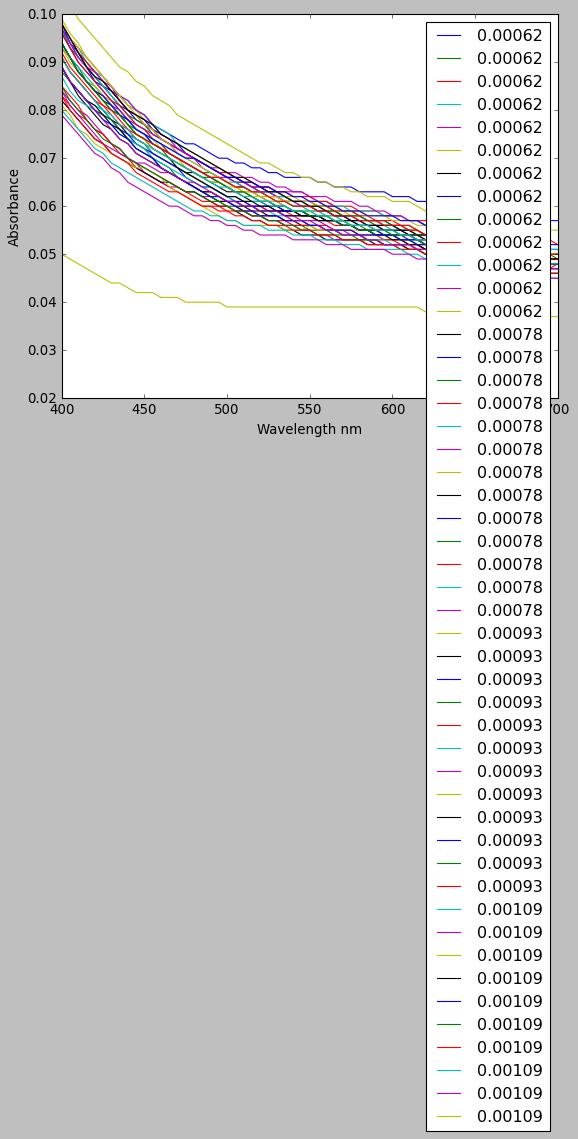

In [37]:
df = plate1
# color_bar = plt.colorbar()
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded[0:96], y_lim=[0.02,0.1]) # so still under resolution
# can you do a color bar like image on this 

In [32]:
plate1_blanked

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Wavelength,400.000,405.000,410.000,415.000,420.000,425.000,430.000,435.000,440.000,445.000,...,655.000,660.000,665.000,670.000,675.000,680.000,685.000,690.000,695.000,700.000
A1,0.048,0.046,0.045,0.044,0.043,0.042,0.041,0.040,0.039,0.038,...,0.021,0.021,0.020,0.020,0.020,0.020,0.019,0.019,0.019,0.019
A2,0.741,0.733,0.727,0.725,0.722,0.725,0.726,0.719,0.715,0.712,...,0.669,0.668,0.670,0.668,0.667,0.667,0.669,0.667,0.666,0.669
A3,0.033,0.032,0.032,0.032,0.031,0.031,0.030,0.028,0.028,0.026,...,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009,0.010
A4,0.048,0.046,0.046,0.044,0.043,0.043,0.042,0.040,0.040,0.038,...,0.013,0.013,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011
A5,0.048,0.046,0.046,0.045,0.044,0.043,0.042,0.039,0.038,0.037,...,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011,0.011,0.011
A6,0.055,0.053,0.052,0.051,0.050,0.049,0.048,0.046,0.046,0.044,...,0.019,0.019,0.019,0.018,0.018,0.018,0.018,0.018,0.017,0.017
A7,0.041,0.039,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,...,0.011,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009
A8,0.048,0.045,0.045,0.043,0.042,0.041,0.041,0.039,0.038,0.036,...,0.014,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.012
B1,0.044,0.042,0.041,0.040,0.040,0.039,0.038,0.036,0.035,0.034,...,0.013,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.011
